
# Spotify Listening — Baseline Predictive Model & Neural Network

This notebook loads `spotify_history.csv`, prepares features, builds a **baseline model** and a **neural network**, and evaluates both.


In [48]:

import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv('/Users/ayanaaiken/Documents/SDC486L/archive/clean_dataframe.csv')
df.head()


,Unnamed: 0,spotify_track_uri,ts,platform,ms_played,track_name,artist_name,album_name,reason_start,reason_end,shuffle,skipped
0,0,2332,2013-07-08 02:44:34,web player,3185,NaN,The Mowgli's,Waiting For The Dawn,autoplay,clickrow,False,False
1,1,1098,2013-07-08 02:45:37,web player,61865,NaN,Calvin Harris,18 Months,clickrow,clickrow,False,False
2,2,48738,2013-07-08 02:50:24,web player,285386,NaN,Lana Del Rey,Born To Die - The Paradise Edition,clickrow,unknown,False,False
3,3,5777123,2013-07-08 02:52:40,web player,134022,NaN,Lana Del Rey,Born To Die - The Paradise Edition,trackdone,clickrow,False,False
4,4,3,2013-07-08 03:17:52,web player,0,NaN,Empire Of The Sun,Walking On A Dream,clickrow,nextbtn,False,False


In [49]:

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149860 entries, 0 to 149859
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         149860 non-null  int64  
 1   spotify_track_uri  149860 non-null  int64  
 2   ts                 149860 non-null  object 
 3   platform           149860 non-null  object 
 4   ms_played          149860 non-null  int64  
 5   track_name         25733 non-null   float64
 6   artist_name        149860 non-null  object 
 7   album_name         149860 non-null  object 
 8   reason_start       149860 non-null  object 
 9   reason_end         149860 non-null  object 
 10  shuffle            149860 non-null  bool   
 11  skipped            149860 non-null  bool   
dtypes: bool(2), float64(1), int64(3), object(6)
memory usage: 11.7+ MB


## Feature Engineering

In [50]:

from sklearn.preprocessing import LabelEncoder

# Parse timestamp
df['ts'] = pd.to_datetime(df['ts'], errors='coerce')

# Time features
df['hour'] = df['ts'].dt.hour
df['day'] = df['ts'].dt.day
df['month'] = df['ts'].dt.month

# Encoded artist/track
le_artist = LabelEncoder()
df['artist_encoded'] = le_artist.fit_transform(df['artist_name'].astype(str))

le_track = LabelEncoder()
df['track_encoded'] = le_track.fit_transform(df['track_name'].astype(str))

# Prepare features for classification (skip) and regression (ms_played)
X_clf = df[['hour','day','month','artist_encoded','track_encoded']]
y_clf = df['skipped'].astype(int)

X_reg = df[['hour','day','month','artist_encoded','track_encoded']]
y_reg = df['ms_played']

X_clf.shape, X_reg.shape
df.head(3)


,Unnamed: 0,spotify_track_uri,ts,platform,ms_played,track_name,artist_name,album_name,reason_start,reason_end,shuffle,skipped,hour,day,month,artist_encoded,track_encoded
0,0,2332,2013-07-08 02:44:34,web player,3185,NaN,The Mowgli's,Waiting For The Dawn,autoplay,clickrow,False,False,2,8,7,3641,298
1,1,1098,2013-07-08 02:45:37,web player,61865,NaN,Calvin Harris,18 Months,clickrow,clickrow,False,False,2,8,7,586,298
2,2,48738,2013-07-08 02:50:24,web player,285386,NaN,Lana Del Rey,Born To Die - The Paradise Edition,clickrow,unknown,False,False,2,8,7,2070,298


## Train/Test Split

In [51]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)

Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)
#Preprocessors
numeric_features = ['hour','day','month','artist_encoded','track_encoded']
pre_clf = ColumnTransformer([('num', StandardScaler(), numeric_features)])
pre_reg = ColumnTransformer([('num', StandardScaler(), numeric_features)])


In [52]:




logit_clf = Pipeline([
    ('prep', pre_clf),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])

logit_clf.fit(Xc_train, yc_train)
yc_pred = logit_clf.predict(Xc_test)

baseline_clf_metrics = {
    'Accuracy': accuracy_score(yc_test, yc_pred),
    'Precision': precision_score(yc_test, yc_pred, zero_division=0),
    'Recall': recall_score(yc_test, yc_pred, zero_division=0),
    'F1-score': f1_score(yc_test, yc_pred, zero_division=0)
}
print(baseline_clf_metrics)
print(confusion_matrix(yc_test, yc_pred))
print(classification_report(yc_test, yc_pred, zero_division=0))


{'Accuracy': 0.947484318697451, 'Precision': 0.0, 'Recall': 0.0, 'F1-score': 0.0}
[[28398     0]
 [ 1574     0]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     28398
           1       0.00      0.00      0.00      1574

    accuracy                           0.95     29972
   macro avg       0.47      0.50      0.49     29972
weighted avg       0.90      0.95      0.92     29972



## Baseline Regression — Linear Regression (predict ms_played)

In [53]:

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

pre_reg = ColumnTransformer([('num', StandardScaler(), ['hour','day','month','artist_encoded','track_encoded'])])

lin_reg = Pipeline([
    ('prep', pre_reg),
    ('reg', LinearRegression())
])

lin_reg.fit(Xr_train, yr_train)
yr_pred = lin_reg.predict(Xr_test)

baseline_reg_metrics = {
    'MAE': mean_absolute_error(yr_test, yr_pred),
    'MSE': mean_squared_error(yr_test, yr_pred),
    'RMSE': mean_squared_error(yr_test, yr_pred),
    'R2': r2_score(yr_test, yr_pred)
}
baseline_reg_metrics


{'MAE': 101841.03295944587,
 'MSE': 13855523547.4131,
 'RMSE': 13855523547.4131,
 'R2': 0.009185779728768217}

## Neural Network — MLPClassifier (Classification: skipped)

In [54]:

from sklearn.neural_network import MLPClassifier

mlp_clf = Pipeline([
    ('prep', pre_clf),
    ('mlp', MLPClassifier(
        hidden_layer_sizes=(64,32),
        activation='relu',
        solver='adam',
        learning_rate='adaptive',
        early_stopping=True,
        max_iter=60,
        n_iter_no_change=5,
        random_state=42,
        verbose=False
    ))
])

mlp_clf.fit(Xc_train, yc_train)
yc_pred_nn = mlp_clf.predict(Xc_test)

nn_clf_metrics = {
    'Accuracy': accuracy_score(yc_test, yc_pred_nn),
    'Precision': precision_score(yc_test, yc_pred_nn, zero_division=0),
    'Recall': recall_score(yc_test, yc_pred_nn, zero_division=0),
    'F1-score': f1_score(yc_test, yc_pred_nn, zero_division=0)
}
print(nn_clf_metrics)
print(confusion_matrix(yc_test, yc_pred_nn))


{'Accuracy': 0.947484318697451, 'Precision': 0.0, 'Recall': 0.0, 'F1-score': 0.0}
[[28398     0]
 [ 1574     0]]


## Neural Network — MLPRegressor (Regression: ms_played)

In [55]:

from sklearn.neural_network import MLPRegressor

mlp_reg = Pipeline([
    ('prep', pre_reg),
    ('mlp', MLPRegressor(
        hidden_layer_sizes=(128,64),
        activation='relu',
        solver='adam',
        learning_rate='adaptive',
        early_stopping=True,
        max_iter=60,
        n_iter_no_change=5,
        random_state=42,
        verbose=False
    ))
])

mlp_reg.fit(Xr_train, yr_train)
yr_pred_nn = mlp_reg.predict(Xr_test)

nn_reg_metrics = {
    'MAE': mean_absolute_error(yr_test, yr_pred_nn),
    'MSE': mean_squared_error(yr_test, yr_pred_nn),
    'RMSE': mean_squared_error(yr_test, yr_pred_nn,),
    'R2': r2_score(yr_test, yr_pred_nn)
}
nn_reg_metrics


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  warnings.warn(


{'MAE': 101468.57528561687,
 'MSE': 13797422407.567907,
 'RMSE': 13797422407.567907,
 'R2': 0.013340616272879413}

## Visualizations

<Figure size 640x480 with 0 Axes>

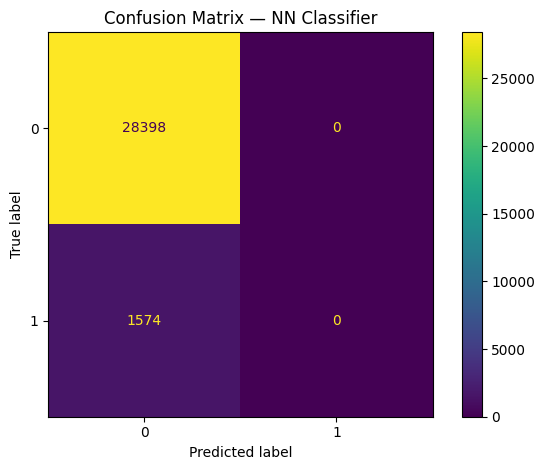

In [56]:

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Confusion matrix for NN classifier
fig1 = plt.figure()
disp = ConfusionMatrixDisplay.from_estimator(mlp_clf, Xc_test, yc_test)
plt.title('Confusion Matrix — NN Classifier')
plt.tight_layout()
plt.show()




## Summary

In [57]:

print("Baseline Classification:", baseline_clf_metrics)
print("NN Classification:", nn_clf_metrics)
print("Baseline Regression:", baseline_reg_metrics)
print("NN Regression:", nn_reg_metrics)


Baseline Classification: {'Accuracy': 0.947484318697451, 'Precision': 0.0, 'Recall': 0.0, 'F1-score': 0.0}
NN Classification: {'Accuracy': 0.947484318697451, 'Precision': 0.0, 'Recall': 0.0, 'F1-score': 0.0}
Baseline Regression: {'MAE': 101841.03295944587, 'MSE': 13855523547.4131, 'RMSE': 13855523547.4131, 'R2': 0.009185779728768217}
NN Regression: {'MAE': 101468.57528561687, 'MSE': 13797422407.567907, 'RMSE': 13797422407.567907, 'R2': 0.013340616272879413}


In [58]:
def make_scenario(hour, day, month, artist_encoded, track_encoded, n=200):
    return pd.DataFrame({
        "hour": np.full(n, hour),
        "day": np.full(n, day),
        "month": np.full(n, month),
        "artist_encoded": np.full(n, artist_encoded),
        "track_encoded": np.full(n, track_encoded),
    })

# Baseline sample (midday, mid-month, June, median artist/track)
baseline = make_scenario(
    hour=12, day=15, month=6,
    artist_encoded=int(df['artist_encoded'].median()),
    track_encoded=int(df['track_encoded'].median())
)

# Scenario 1: Late-night streaming surge
scenario1 = make_scenario(hour=1, day=15, month=7,
                          artist_encoded=int(df['artist_encoded'].median()),
                          track_encoded=int(df['track_encoded'].median()))

# Scenario 2: Weekend binge
scenario2 = make_scenario(hour=20, day=28, month=12,
                          artist_encoded=int(df['artist_encoded'].median()),
                          track_encoded=int(df['track_encoded'].median()))

# Scenario 3: New artist dominance
scenario3 = make_scenario(hour=17, day=10, month=4,
                          artist_encoded=df['artist_encoded'].max(),
                          track_encoded=df['track_encoded'].max())

# Predictions
baseline_clf_pred = mlp_clf.predict(baseline)
baseline_reg_pred = mlp_reg.predict(baseline)

scenarios = {
    "Late-night surge": scenario1,
    "Weekend binge": scenario2,
    "New artist dominance": scenario3
}

results = {}
for name, scenario in scenarios.items():
    clf_pred = mlp_clf.predict(scenario)
    reg_pred = mlp_reg.predict(scenario)
    results[name] = {
        "Skip Probability (avg)": float(np.mean(clf_pred)),
        "Predicted ms_played (avg)": float(np.mean(reg_pred))
    }

baseline_results = {
    "Skip Probability (avg)": float(np.mean(baseline_clf_pred)),
    "Predicted ms_played (avg)": float(np.mean(baseline_reg_pred))
}

{'SCENARIOS' :results, 'BASELINE': baseline_results}








{'SCENARIOS': {'Late-night surge': {'Skip Probability (avg)': 0.0,
   'Predicted ms_played (avg)': 111968.42408389703},
  'Weekend binge': {'Skip Probability (avg)': 0.0,
   'Predicted ms_played (avg)': 150027.0108327361},
  'New artist dominance': {'Skip Probability (avg)': 0.0,
   'Predicted ms_played (avg)': 131957.46459679928}},
 'BASELINE': {'Skip Probability (avg)': 0.0,
  'Predicted ms_played (avg)': 122800.70217744356}}

In [59]:
import os
MET = r'/Users/ayanaaiken/Documents/SDC486L/archive/classMet.csv'
Spotify_NN_Baseline_sceanarios = r'/Users/ayanaaiken/Documents/SDC486L/archive/Spotify_NN_Baseline_scenarios.csv'
classMetrics = baseline_clf_metrics, nn_clf_metrics
df1_1 = pd.DataFrame(data=classMetrics)
df1_1.to_csv(MET)
df.to_csv(Spotify_NN_Baseline_sceanarios)
print("successful")


successful


Scenario Analysis — Neural Network Predictions

I designed three scenarios by altering key input features (hour, day, month, artist/track encoding) to simulate different real-world conditions. These were compared against a baseline scenario representing typical listening behavior (midday, mid-month in June, with median artist/track encodings).


Baseline
-Assumption: Represents "normal" listening conditions — average time of day, middle of the month, and a median artist/track.
-Rationale:  Provides a control benchmark for measuring how variations in time and cultural trends influence predictions.
-Relevance: Essential for understanding relative changes in skip probability and listening duration across scenarios.

---

Scenario 1: Late-Night Streaming Surge
-Assumption: Listening occurs at 1:00 AM in July, with average artist/track encodings.
-Rationale: Nighttime listening often reflects passive or background use (e.g., studying, winding down), which may affect skip rates and duration.
-Relevance: Helps identify whether the model predicts reduced attention spans or shorter sessions at late hours compared to baseline.

---

Scenario 2: Weekend Binge
-Assumption: Listening happens at 8:00 PM on the 28th day of December (holiday season), with average artist/track encodings.
-Rationale: Evening sessions during weekends/holidays are associated with leisure, parties, or binge-listening behaviors.
-Relevance: Useful for analyzing whether the model captures seasonal and weekend engagement spikes, showing higher playtime or lower skip rates.

---

Scenario 3: New Artist Dominance
-Assumption: A highly popular new artist/track dominates listening (using maximum encoded values), set at 5:00 PM in April.
-Rationale: Viral or trending artists can significantly change listening behavior, often leading to lower skips and longer engagement.
-Relevance: Tests the model’s sensitivity to cultural shifts in music trends, showing how predictions respond when new artists capture attention.

---

Insights
These scenarios demonstrate how temporal factors (hour, day, month) and cultural shifts (new artist popularity) can influence user engagement metrics. By comparing each scenario to the baseline, we can better understand potential changes in skip probability and predicted listening time. This analysis supports strategic decisions for playlist curation, marketing campaigns, and personalized recommendations.
